## Weather Prediction:  A comparision of traditional and modern methods

In this study, we are going to use Python and Machine Learning to build models to predict weather temperatures based off data from WorldWeatherOnline. There are three "phases" to this study:

1. Data collection and processing (i.e. like doing an experiment!)
2. Using Linear Regression models (i.e. a traditional fitting approach)
3. Using Neural Network models (i.e. a machine-learning approach)

The data used will be collected from the WorldWeatherOnline API web services. We will interact with the API to pull in weather data over a given time period, for a given location.

Once collected, the data will need to be processed and aggregated into a format that is suitable for data analysis, and then cleaned.

In [1]:
# import the usual libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats

# We are going to need several additional libraries.  We import them here, but
# I will discuss their purpose and give further details as they are used.

In [2]:
import os
os.chdir("/home/brash/Phys421/WWO")
df = pd.read_csv('regina.csv')

In [3]:
df.head()

,date_time,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,moonrise,moonset,sunrise,...,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,location
0,2019-12-11 00:00:00,-18,-25,0.0,3.0,2,99,04:50 PM,08:02 AM,08:49 AM,...,10,16,91,0.0,1034,-25,10,214,5,regina
1,2019-12-11 03:00:00,-18,-25,0.0,3.0,2,99,04:50 PM,08:02 AM,08:49 AM,...,4,71,86,0.0,1033,-24,10,206,3,regina
2,2019-12-11 06:00:00,-18,-25,0.0,3.0,2,99,04:50 PM,08:02 AM,08:49 AM,...,7,100,82,0.0,1032,-22,10,143,5,regina
3,2019-12-11 09:00:00,-18,-25,0.0,3.0,2,99,04:50 PM,08:02 AM,08:49 AM,...,12,100,82,0.0,1030,-21,10,143,9,regina
4,2019-12-11 12:00:00,-18,-25,0.0,3.0,2,99,04:50 PM,08:02 AM,08:49 AM,...,16,100,82,0.0,1029,-19,10,135,12,regina


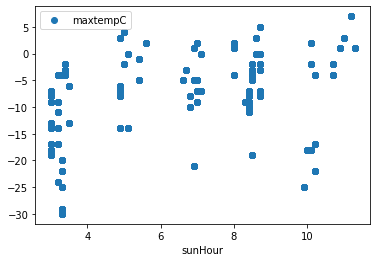

In [4]:
df.plot('sunHour','maxtempC',style='o')

In [5]:
df.describe()

,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
count,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000
mean,-7.880435,-14.413043,0.035870,6.341304,1.456522,48.054348,-12.002717,-16.706522,-10.582880,-16.706522,26.054348,59.896739,89.127717,0.024049,1018.184783,-10.767663,8.489130,227.612772,14.906250
std,8.242373,7.953815,0.106987,2.699142,0.498445,32.226533,7.711816,9.633319,8.091899,9.633319,10.608034,35.157414,6.416814,0.092467,10.845286,8.166571,2.722522,76.321595,6.601642
min,-30.000000,-34.000000,0.000000,3.000000,1.000000,0.000000,-35.000000,-42.000000,-34.000000,-42.000000,4.000000,0.000000,60.000000,0.000000,989.000000,-34.000000,0.000000,9.000000,2.000000
25%,-13.250000,-19.000000,0.000000,3.300000,1.000000,20.250000,-16.250000,-23.000000,-15.250000,-23.000000,18.000000,27.000000,85.000000,0.000000,1012.000000,-16.000000,7.000000,156.000000,10.000000
50%,-6.500000,-13.000000,0.000000,6.800000,1.000000,48.000000,-10.000000,-15.000000,-9.000000,-15.000000,25.000000,70.000000,91.000000,0.000000,1018.000000,-9.000000,10.000000,235.000000,14.000000
75%,-2.000000,-9.000000,0.000000,8.500000,2.000000,75.250000,-7.000000,-10.000000,-5.000000,-10.000000,33.000000,95.000000,94.000000,0.000000,1024.000000,-5.000000,10.000000,298.000000,19.000000
max,7.000000,-1.000000,0.800000,11.300000,2.000000,100.000000,3.000000,3.000000,6.000000,3.000000,65.000000,100.000000,99.000000,1.200000,1048.000000,6.000000,10.000000,350.000000,41.000000


In [6]:
# Create new feature columns ... the idea is that we are going to
# try to predict the temperature for tomorrow by looking at what
# happened today, and for the past three days.

# For each feature that we think might be an important factor in
# determining out temperature forecast, we will add a column to the
# dataframe for this variable for each of the previous three days.

def derive_nth_day_feature(df, feature, N):
    rows = df.shape[0]
    nth_prior_measurements = [None]*N + [df[feature][i-N] for i in range(N, rows)]
    col_name = "{}_{}".format(feature, N)
    df[col_name] = nth_prior_measurements

In [7]:
# These are the features/variables that we think a priori might be
# important in our forecasting model

features = ["date_time", "tempC", "DewPointC","pressure","humidity",
            "maxtempC", "mintempC", "sunHour", "windspeedKmph",
            "winddirDegree","precipMM"]


In [8]:
# Now, for each of these features, add three new columns to the
# dataframe which correspond to yesterday, the day before yesterday,
# and the day before that.  The column names will be the same as
# the name as the original feature, but with _1, _2, or _3 added on.

for feature in features:
    if feature != 'date_time':
        for N in range(1, 4):
            derive_nth_day_feature(df, feature, N)

In [9]:
# We see now that we have accomplished our task ... a lot of new
# columns have been added!

df.columns

Index(['date_time', 'maxtempC', 'mintempC', 'totalSnow_cm', 'sunHour',
       'uvIndex', 'moon_illumination', 'moonrise', 'moonset', 'sunrise',
       'sunset', 'DewPointC', 'FeelsLikeC', 'HeatIndexC', 'WindChillC',
       'WindGustKmph', 'cloudcover', 'humidity', 'precipMM', 'pressure',
       'tempC', 'visibility', 'winddirDegree', 'windspeedKmph', 'location',
       'tempC_1', 'tempC_2', 'tempC_3', 'DewPointC_1', 'DewPointC_2',
       'DewPointC_3', 'pressure_1', 'pressure_2', 'pressure_3', 'humidity_1',
       'humidity_2', 'humidity_3', 'maxtempC_1', 'maxtempC_2', 'maxtempC_3',
       'mintempC_1', 'mintempC_2', 'mintempC_3', 'sunHour_1', 'sunHour_2',
       'sunHour_3', 'windspeedKmph_1', 'windspeedKmph_2', 'windspeedKmph_3',
       'winddirDegree_1', 'winddirDegree_2', 'winddirDegree_3', 'precipMM_1',
       'precipMM_2', 'precipMM_3'],
      dtype='object')

In [10]:
# We now want to clean up the dataframe, and get rid of columns that
# we are not interested in.  This is not so important in this example,
# but if we are dealing with large dataframes with thousands of columns
# of data, it can really speed things up by condensing things.

# make list of original features we are not interested in
to_remove = [feature 
             for feature in features 
             if feature not in ['date_time','maxtempC', 'mintempC', 'tempC']]
for col in ['DewPointC','pressure','humidity','sunHour',
                'windspeedKmph','winddirDegree','precipMM',
                 'totalSnow_cm','uvIndex','moon_illumination',
                  'moonrise','moonset','sunrise','sunset','FeelsLikeC',
                 'HeatIndexC','WindChillC','WindGustKmph','cloudcover',
                 'visibility','location']:
    to_remove.append(col)

print(to_remove)

# make a list of columns to keep
to_keep = [col for col in df.columns if col not in to_remove]

print(to_keep)

# select only the columns in to_keep and assign to df
df = df[to_keep]
df.columns

['DewPointC', 'pressure', 'humidity', 'sunHour', 'windspeedKmph', 'winddirDegree', 'precipMM', 'DewPointC', 'pressure', 'humidity', 'sunHour', 'windspeedKmph', 'winddirDegree', 'precipMM', 'totalSnow_cm', 'uvIndex', 'moon_illumination', 'moonrise', 'moonset', 'sunrise', 'sunset', 'FeelsLikeC', 'HeatIndexC', 'WindChillC', 'WindGustKmph', 'cloudcover', 'visibility', 'location']
['date_time', 'maxtempC', 'mintempC', 'tempC', 'tempC_1', 'tempC_2', 'tempC_3', 'DewPointC_1', 'DewPointC_2', 'DewPointC_3', 'pressure_1', 'pressure_2', 'pressure_3', 'humidity_1', 'humidity_2', 'humidity_3', 'maxtempC_1', 'maxtempC_2', 'maxtempC_3', 'mintempC_1', 'mintempC_2', 'mintempC_3', 'sunHour_1', 'sunHour_2', 'sunHour_3', 'windspeedKmph_1', 'windspeedKmph_2', 'windspeedKmph_3', 'winddirDegree_1', 'winddirDegree_2', 'winddirDegree_3', 'precipMM_1', 'precipMM_2', 'precipMM_3']


Index(['date_time', 'maxtempC', 'mintempC', 'tempC', 'tempC_1', 'tempC_2',
       'tempC_3', 'DewPointC_1', 'DewPointC_2', 'DewPointC_3', 'pressure_1',
       'pressure_2', 'pressure_3', 'humidity_1', 'humidity_2', 'humidity_3',
       'maxtempC_1', 'maxtempC_2', 'maxtempC_3', 'mintempC_1', 'mintempC_2',
       'mintempC_3', 'sunHour_1', 'sunHour_2', 'sunHour_3', 'windspeedKmph_1',
       'windspeedKmph_2', 'windspeedKmph_3', 'winddirDegree_1',
       'winddirDegree_2', 'winddirDegree_3', 'precipMM_1', 'precipMM_2',
       'precipMM_3'],
      dtype='object')

In [11]:
# If we look at the dataframe now, we see that we have just the
# columns that we are interested in.  All of the columns are either
# integers or floats, and so we don't need to do anything else.

# However, we also notice that for some columns, we are missing a few
# data points.  The reason for this is simple:  If we are looking back
# several days, the first entry in the column for a particular variable
# is not going to have any data associated with it for previous days,
# the second entry in a column will only have data for the previous day,
# etc.  We can handle this by droping rows that do not have complete data!

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 736 entries, 0 to 735
Data columns (total 34 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date_time        736 non-null    object 
 1   maxtempC         736 non-null    int64  
 2   mintempC         736 non-null    int64  
 3   tempC            736 non-null    int64  
 4   tempC_1          735 non-null    float64
 5   tempC_2          734 non-null    float64
 6   tempC_3          733 non-null    float64
 7   DewPointC_1      735 non-null    float64
 8   DewPointC_2      734 non-null    float64
 9   DewPointC_3      733 non-null    float64
 10  pressure_1       735 non-null    float64
 11  pressure_2       734 non-null    float64
 12  pressure_3       733 non-null    float64
 13  humidity_1       735 non-null    float64
 14  humidity_2       734 non-null    float64
 15  humidity_3       733 non-null    float64
 16  maxtempC_1       735 non-null    float64
 17  maxtempC_2      

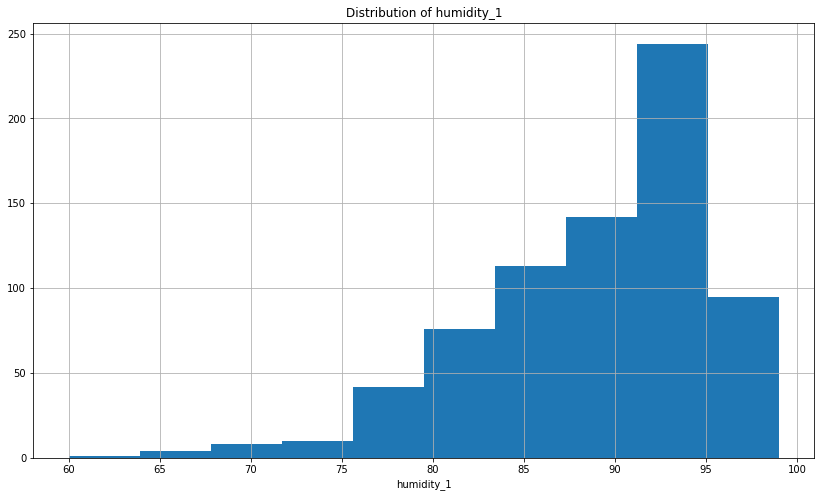

In [12]:
# Let us now look at a few of the columns of data
#
# We see that humidity, for example, is NOT a normal distribution!  We
# should remember that, going forward, as it may end up causing issues.

%matplotlib inline
plt.rcParams['figure.figsize'] = [14, 8]
df.humidity_1.hist()
plt.title('Distribution of humidity_1')
plt.xlabel('humidity_1')
plt.show()

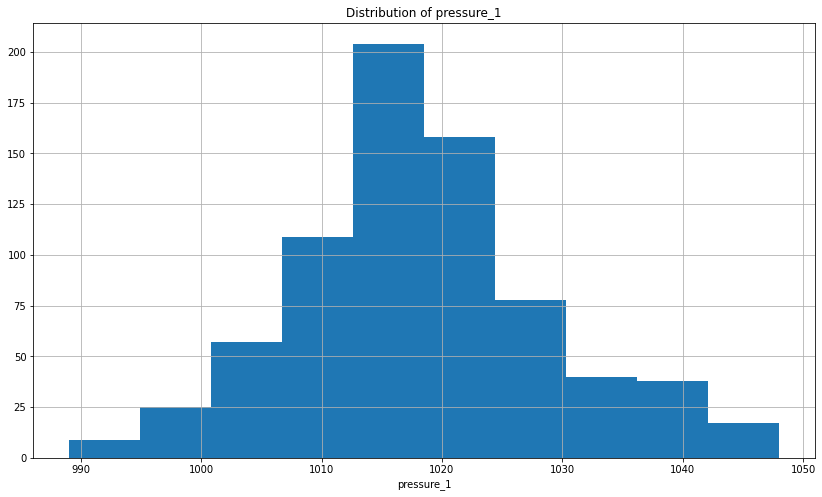

In [13]:
# The pressure, on the other hand, looks like a nice Gaussian distribution.
# We really should look at EVERY column in this manner, and try to determine
# if the distribution is normal, and if there are any bad data points (outliers).

df.pressure_1.hist()
plt.title('Distribution of pressure_1')
plt.xlabel('pressure_1')
plt.show()

In [14]:
df.describe()

,maxtempC,mintempC,tempC,tempC_1,tempC_2,tempC_3,DewPointC_1,DewPointC_2,DewPointC_3,pressure_1,...,sunHour_3,windspeedKmph_1,windspeedKmph_2,windspeedKmph_3,winddirDegree_1,winddirDegree_2,winddirDegree_3,precipMM_1,precipMM_2,precipMM_3
count,736.000000,736.000000,736.000000,735.000000,734.000000,733.000000,735.000000,734.000000,733.000000,735.000000,...,733.000000,735.000000,734.000000,733.000000,735.000000,734.000000,733.000000,735.000000,734.000000,733.000000
mean,-7.880435,-14.413043,-10.767663,-10.782313,-10.798365,-10.815825,-12.014966,-12.028610,-12.043656,1018.201361,...,6.325921,14.896599,14.886921,14.875853,227.508844,227.411444,227.327422,0.024082,0.023978,0.023602
std,8.242373,7.953815,8.166571,8.162449,8.156397,8.148229,7.709900,7.706272,7.700738,10.843336,...,2.693898,6.600939,6.600221,6.597907,76.321435,76.327754,76.345897,0.092526,0.092546,0.092045
min,-30.000000,-34.000000,-34.000000,-34.000000,-34.000000,-34.000000,-35.000000,-35.000000,-35.000000,989.000000,...,3.000000,2.000000,2.000000,2.000000,9.000000,9.000000,9.000000,0.000000,0.000000,0.000000
25%,-13.250000,-19.000000,-16.000000,-16.000000,-16.000000,-16.000000,-16.500000,-16.750000,-17.000000,1012.000000,...,3.300000,10.000000,10.000000,10.000000,156.000000,156.000000,156.000000,0.000000,0.000000,0.000000
50%,-6.500000,-13.000000,-9.000000,-9.000000,-9.000000,-9.000000,-10.000000,-10.000000,-10.000000,1018.000000,...,6.800000,14.000000,14.000000,14.000000,235.000000,235.000000,235.000000,0.000000,0.000000,0.000000
75%,-2.000000,-9.000000,-5.000000,-5.000000,-5.000000,-5.000000,-7.000000,-7.000000,-7.000000,1024.000000,...,8.500000,18.500000,18.000000,18.000000,298.000000,297.750000,298.000000,0.000000,0.000000,0.000000
max,7.000000,-1.000000,6.000000,6.000000,6.000000,6.000000,3.000000,3.000000,3.000000,1048.000000,...,11.300000,41.000000,41.000000,41.000000,350.000000,350.000000,350.000000,1.200000,1.200000,1.200000


In [15]:
# Now, let's get rid of the rows that do not have complete data!

df = df.dropna()

In [16]:
df.describe()

,maxtempC,mintempC,tempC,tempC_1,tempC_2,tempC_3,DewPointC_1,DewPointC_2,DewPointC_3,pressure_1,...,sunHour_3,windspeedKmph_1,windspeedKmph_2,windspeedKmph_3,winddirDegree_1,winddirDegree_2,winddirDegree_3,precipMM_1,precipMM_2,precipMM_3
count,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,...,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000
mean,-7.839018,-14.369714,-10.714870,-10.744884,-10.778990,-10.815825,-11.976808,-12.009550,-12.043656,1018.159618,...,6.325921,14.926330,14.900409,14.875853,227.556617,227.429741,227.327422,0.024147,0.024011,0.023602
std,8.233694,7.941109,8.140955,8.141952,8.145047,8.148229,7.685645,7.694201,7.700738,10.828540,...,2.693898,6.585091,6.594596,6.597907,76.419847,76.378262,76.345897,0.092643,0.092605,0.092045
min,-30.000000,-34.000000,-34.000000,-34.000000,-34.000000,-34.000000,-35.000000,-35.000000,-35.000000,989.000000,...,3.000000,2.000000,2.000000,2.000000,9.000000,9.000000,9.000000,0.000000,0.000000,0.000000
25%,-13.000000,-19.000000,-16.000000,-16.000000,-16.000000,-16.000000,-16.000000,-16.000000,-17.000000,1012.000000,...,3.300000,10.000000,10.000000,10.000000,156.000000,156.000000,156.000000,0.000000,0.000000,0.000000
50%,-6.000000,-13.000000,-9.000000,-9.000000,-9.000000,-9.000000,-10.000000,-10.000000,-10.000000,1018.000000,...,6.800000,14.000000,14.000000,14.000000,235.000000,235.000000,235.000000,0.000000,0.000000,0.000000
75%,-2.000000,-9.000000,-5.000000,-5.000000,-5.000000,-5.000000,-7.000000,-7.000000,-7.000000,1024.000000,...,8.500000,19.000000,18.000000,18.000000,298.000000,298.000000,298.000000,0.000000,0.000000,0.000000
max,7.000000,-1.000000,6.000000,6.000000,6.000000,6.000000,3.000000,3.000000,3.000000,1048.000000,...,11.300000,41.000000,41.000000,41.000000,350.000000,350.000000,350.000000,1.200000,1.200000,1.200000


## We are now ready to do a linear regression fit to the data!!

In [17]:
# our first task is to determine what the important variables/features are!
#
# The corr() method of the dataframe object will return the Pearson correlation
# coefficient, r, which measures the amount of correlation between two variables.
#
# Values close to 1 indicate a strong positive correlation; values close to -1
# indicate a strong negative correlation, and values close to zero indicate little
# correlation.  We want to look at the correlation between all of the variables in
# our dataframe with the daily mean temperature (tempC).  We will also sort these 
# values from smallest to largest.
#
# Perhaps not surprisingly, the strongest positive correlations come from looking at
# the temperature in the previous days.  The strongest negative correlations are
# associated with pressure and temperature.  That is, if the pressure is low, 
# the temperatures tend to be a little higher, and vice versa, and if the humidity is low
# the temperatures tend to be a little higher, and vice versa.

df.corr()[['tempC']].sort_values('tempC')

,tempC
pressure_1,-0.751092
pressure_2,-0.714278
pressure_3,-0.663626
humidity_1,-0.390127
humidity_2,-0.377720
humidity_3,-0.365741
winddirDegree_3,-0.180991
winddirDegree_2,-0.143677
winddirDegree_1,-0.093068
precipMM_3,-0.079001


In [18]:
# for our model, we will only include variables where the abs(r) > 0.5 - that is, either
# a strong positive or strong negative correlation.

predictors = ['tempC_1',  'DewPointC_1',  'maxtempC_2', 
              'maxtempC_1',   'mintempC_1',   'maxtempC_3',
              'mintempC', 'maxtempC', 'mintempC_2',
              'tempC_2',  'DewPointC_2',  'mintempC_3',
              'tempC_3',  'DewPointC_3',  'pressure_1',
              'pressure_2',   'pressure_3', 'humidity_1']
df2 = df[['date_time']+['tempC'] + predictors]

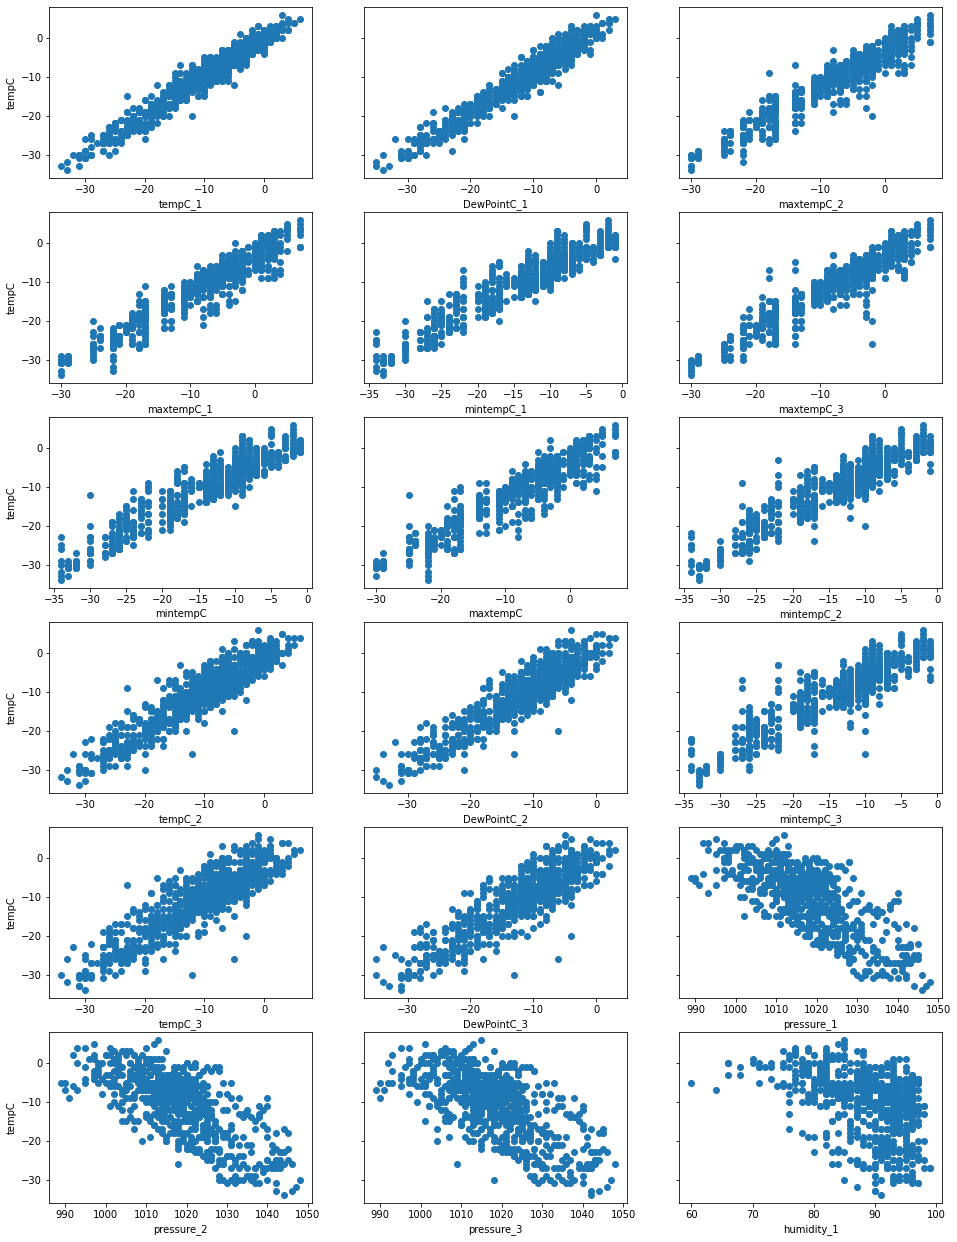

In [19]:
plt.rcParams['figure.figsize'] = [16, 22]
fig, axes = plt.subplots(nrows=6, ncols=3, sharey=True)
arr = np.array(predictors).reshape(6, 3)

for row, col_arr in enumerate(arr):
    for col, feature in enumerate(col_arr):
        axes[row, col].scatter(df2[feature], df2['tempC'])
        if col == 0:
            axes[row, col].set(xlabel=feature, ylabel='tempC')
        else:
            axes[row, col].set(xlabel=feature)
plt.show()

In [20]:
# import the relevant module
import statsmodels.api as sm

# separate our my predictor variables (X) from my outcome variable y
X = df2[predictors]
y = df2['tempC']

# Add a constant to the predictor variable set to represent the Bo intercept
X = sm.add_constant(X)

In [21]:
# (1) select a significance value
alpha = 0.05

# (2) Fit the model
model = sm.OLS(y, X).fit()

# (3) evaluate the coefficients' p-values
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  tempC   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     1906.
Date:                Sat, 26 Sep 2020   Prob (F-statistic):               0.00
Time:                        19:09:32   Log-Likelihood:                -1149.9
No. Observations:                 733   AIC:                             2338.
Df Residuals:                     714   BIC:                             2425.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          32.2487      7.099      4.543      0.000      18.311      46.187
tempC_1         0.4756      0.053      9.048      0.000       0.372       0.579
DewPointC_1     0.7690      0.059     13.054      0.000       0.653       0.885
maxtempC_2      0.0249      0.044      0.571      0.568      -0.061       0.111
maxtempC_1      0.0279      0.044      0.640      0.522      -0.058       0.114
mintempC_1     -0.0495      0.050     -0.994      0.321      -0.147       0.048
maxtempC_3      0.0896      0.034      2.657      0.008       0.023       0.156
mintempC        0.1362      0.038      3.605      0.000       0.062       0.210
maxtempC        0.0922      0.032      2.856      0.004       0.029       0.156
mintempC_2      0.0335      0.050      0.676      0.499      -0.064       0.131
tempC_2        -0.4751      0.052     -9.057      0.000      -0.578      -0.372
DewPointC_2    -0.4139      0.072     -5.735      0.000      -0.556      -0.272
mintempC_3      0.0510      0.036      1.404      0.161      -0.020       0.122
tempC_3         0.0789      0.044      1.797      0.073      -0.007       0.165
DewPointC_3     0.1427      0.054      2.658      0.008       0.037       0.248
pressure_1     -0.0499      0.042     -1.177      0.239      -0.133       0.033
pressure_2     -0.0065      0.075     -0.087      0.931      -0.155       0.142
pressure_3      0.0328      0.041      0.806      0.421      -0.047       0.113
humidity_1     -0.0868      0.012     -7.402      0.000      -0.110      -0.064
==============================================================================
Omnibus:                        1.124   Durbin-Watson:                   1.934
Prob(Omnibus):                  0.570   Jarque-Bera (JB):                1.108
Skew:                          -0.095   Prob(JB):                        0.575
Kurtosis:                       2.987   Cond. No.                     2.88e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.88e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [22]:
# Looking at the p-values of this fit, we see that MANY of them are well above the
# threshold alpha=0.05 that we require for significance.  Thus, we should remove these!
#
# If we do not, we are guilty of OVERFITTING the data!!!!!!

X = X.drop('pressure_3', axis=1)
X = X.drop('pressure_2', axis=1)
X = X.drop('pressure_1', axis=1)
X = X.drop('mintempC_3', axis=1)
X = X.drop('mintempC_2', axis=1)
X = X.drop('mintempC_1', axis=1)
X = X.drop('maxtempC_1', axis=1)
X = X.drop('maxtempC_2', axis=1)
X = X.drop('tempC_3', axis=1)
X = X.drop('mintempC', axis=1)
X = X.drop('maxtempC', axis=1)

In [23]:
model = sm.OLS(y, X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  tempC   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     3422.
Date:                Sat, 26 Sep 2020   Prob (F-statistic):               0.00
Time:                        19:09:32   Log-Likelihood:                -1283.8
No. Observations:                 733   AIC:                             2584.
Df Residuals:                     725   BIC:                             2620.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          10.9780      1.150      9.545      0.000       8.720      13.236
tempC_1         0.4808      0.054      8.831      0.000       0.374       0.588
DewPointC_1     1.0773      0.063     17.135      0.000       0.954       1.201
maxtempC_3      0.2107      0.021     10.089      0.000       0.170       0.252
tempC_2        -0.4597      0.050     -9.151      0.000      -0.558      -0.361
DewPointC_2    -0.6162      0.080     -7.726      0.000      -0.773      -0.460
DewPointC_3     0.2981      0.040      7.429      0.000       0.219       0.377
humidity_1     -0.1203      0.012     -9.783      0.000      -0.144      -0.096
==============================================================================
Omnibus:                       40.450   Durbin-Watson:                   1.881
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               48.592
Skew:                          -0.533   Prob(JB):                     2.81e-11
Kurtosis:                       3.674   Cond. No.                     2.08e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.08e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [24]:
beta0 = model.params[0]
beta1 = model.params[1]
beta2 = model.params[2]
beta3 = model.params[3]
beta4 = model.params[4]
beta5 = model.params[5]
beta6 = model.params[6]
beta7 = model.params[7]

yfit = beta0 + beta1*df2['tempC_1'] + beta1*df2['DewPointC_1']+ beta2*df2['maxtempC_3']+beta3*df2['tempC_3']+beta4*df2['DewPointC_2']+beta5*df2['DewPointC_2']+beta6*df2['DewPointC_3']+beta7*df2['humidity_1'] 

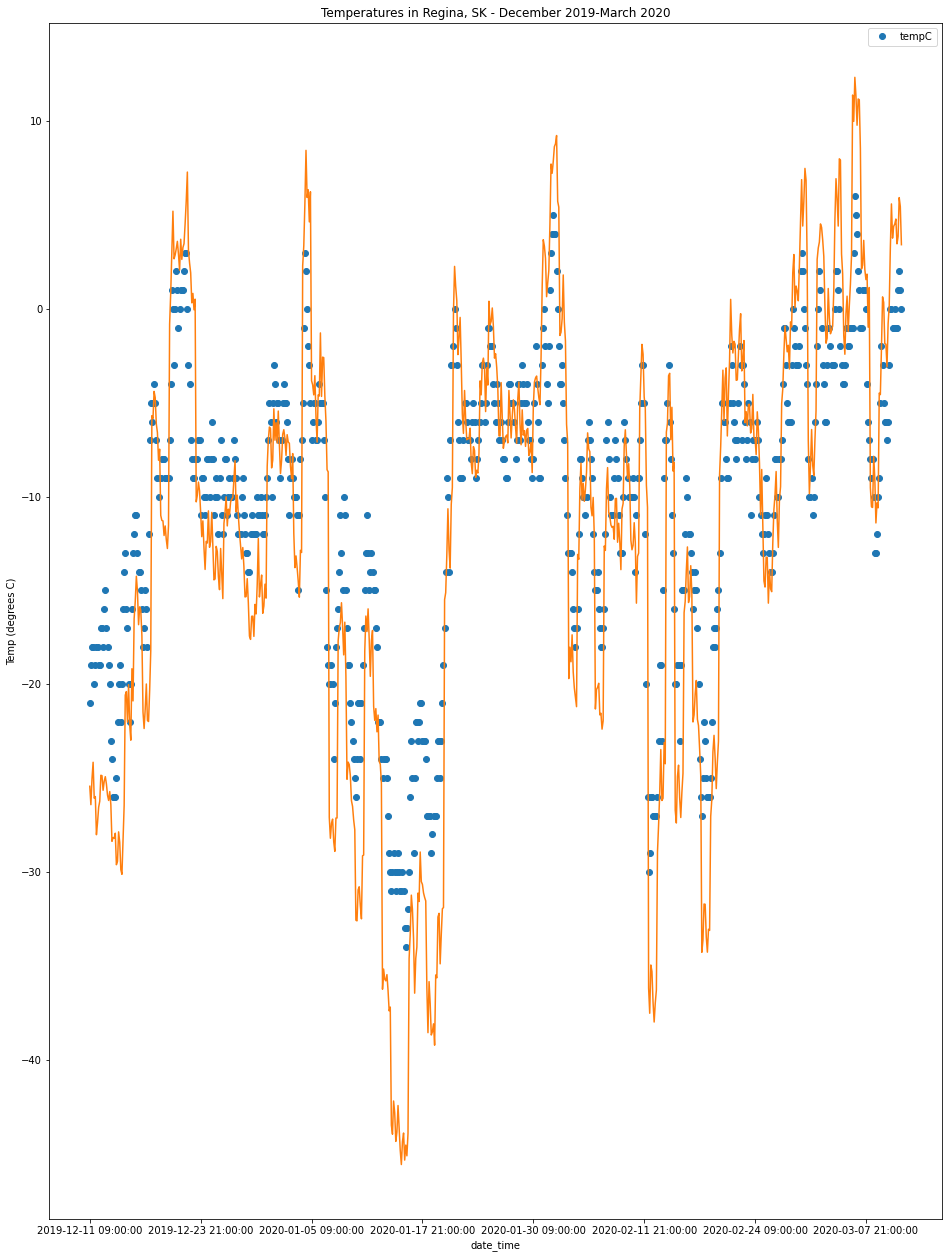

In [25]:
x = df['date_time']

df.plot('date_time','tempC',style='o')
plt.ylabel('Temp (degrees C)')
plt.title('Temperatures in Regina, SK - December 2019-March 2020')
plt.plot(x,yfit)
plt.show()